In [76]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import numpy as np
import requests
import time
import json
import scipy.stats as st
from scipy.stats import linregress

from pprint import pprint

# Impor the DataGov API key
from api_keys import dataapi_key
#from api_keys import census_key


In [11]:
#Define the state abbreviations list
states_abbr = ["CA"]

#Define base URL

base_url = "https://api.usa.gov/crime/fbi/cde/agency/byStateAbbr/"

#Create an empty list to store specific fields
state_abbrs = []
oris = []
agency_ids = []
agency_names = []
agency_type_names = []
county_names = []
latitudes = []
longitudes = []

#Iterate over the state abbreviations list
for state_abbr in states_abbr:
    state_url = f"{base_url}{state_abbr}?API_KEY={dataapi_key}"
    response = requests.get(state_url)
    
    # Check if the request was successful
    if response.status_code == 200:
        state_data = response.json()

        #Extract required data fields from above list
        for agency in state_data:
            agency_ids.append(agency.get('agency_id'))
            agency_names.append(agency.get('agency_name'))
            agency_type_names.append(agency.get('agency_type_name'))
            oris.append(agency.get('ori'))
            county_names.append(agency.get('county_name'))
            state_abbrs.append(agency.get('state_abbr'))
            latitudes.append(agency.get('latitude'))
            longitudes.append(agency.get('longitude'))    
        
    else:
        print(f"Failed to retrieve data for state abbreviation: {state_abbr}")

#Create a DataFrame with the extracted fields
state_agency_data = {
    'agency_id': agency_ids,
    'agency_name': agency_names,
    'agency_type_name': agency_type_names,
    'ori': oris,
    'county_name': county_names,
    'state_abbr': state_abbrs,
    'latitude': latitudes,
    'longitude': longitudes
}

state_agency_data_df = pd.DataFrame(state_agency_data)

# Print the state_data list as needed
state_agency_data_df.head()

,agency_id,agency_name,agency_type_name,ori,county_name,state_abbr,latitude,longitude
0,937,Alameda County Sheriff's Office,County,CA0010000,ALAMEDA,CA,37.802,-122.26236
1,938,Alameda Police Department,City,CA0010100,ALAMEDA,CA,37.766888,-122.24273
2,939,Albany Police Department,City,CA0010200,ALAMEDA,CA,37.887703,-122.29825
3,940,Berkeley Police Department,City,CA0010300,ALAMEDA,CA,37.870537,-122.27298
4,941,Emeryville Police Department,City,CA0010400,ALAMEDA,CA,37.648134,-121.913291


In [12]:
# Export the agencies info into a csv
state_agency_data_df.to_csv("output_data/state_agencies.csv")

In [13]:
# Show Record Count
state_agency_data_df.count()

agency_id           836
agency_name         836
agency_type_name    836
ori                 836
county_name         836
state_abbr          836
latitude            633
longitude           633
dtype: int64

In [17]:
#define the base url
base_url2 = "https://api.usa.gov/crime/fbi/cde/arrest/agency/"

#Set a lit of ori to be pulled for state_agency_data_df:ori column
ori_list = state_agency_data_df['ori']

#Create an empty dictionary to store data for each offense
offenses_data = {}

#Iterate over the list of oris
for ori in ori_list:
    #Query URL for searching all offenses for the current ori
    agency_all_url = f"{base_url2}{ori}/all?from=2017&to=2022&API_KEY={dataapi_key}"
    
    #GET request
    response = requests.get(agency_all_url)
    
    #Check if the request was successful
    if response.status_code == 200:
        # Retrieve the data for each offense from the response JSON
        data = response.json()['data']
        
        #Retrieved data to the offenses_data dictionary with ori as key
        offenses_data[ori] = data

#Create a DataFrame from the collected data
offenses_df = pd.DataFrame()

# Iterate over the dictionary to add data and ORI to the DataFrame
for ori, data in offenses_data.items():
    temp_df = pd.DataFrame(data)
    temp_df['ori_number'] = ori
    offenses_df = pd.concat([offenses_df, temp_df])

#Display the DataFrame
pprint(offenses_df)

    data_year  Aggravated Assault  All Other Offenses (Except Traffic)  Arson  \
0      2017.0               380.0                               1428.0    6.0   
1      2018.0               442.0                               1394.0    7.0   
2      2019.0               353.0                               1163.0    2.0   
3      2020.0               387.0                                826.0    9.0   
4      2022.0               345.0                                800.0    5.0   
..        ...                 ...                                  ...    ...   
0      2019.0                 1.0                                  0.0    0.0   
1      2021.0                 3.0                                 16.0    0.0   
2      2022.0                 4.0                                 41.0    0.0   
0      2021.0                 2.0                                  9.0    0.0   
1      2022.0                 1.0                                 12.0    0.0   

    Burglary  Curfew and Lo

In [18]:
# Export the Offense_Data into a csv
offenses_df.to_csv("output_data/offensesperori_final.csv")

In [172]:
#Read saved data 
county_census_df = pd.read_csv("Resources/county_level_consolidated_with_census_info.csv")

#Display sample data
county_census_df.head()



,Unnamed: 0,county_name,data_year,Crimes Against Persons,Crimes Against Society,Crimes Against Property,POVERTY_RATE,POPULATION
0,0,ALAMEDA,2017,7284,12156,8169,12,1487888
1,1,ALAMEDA,2018,7242,11225,7670,12,1487888
2,2,ALAMEDA,2019,7188,10867,7321,12,1487888
3,3,ALAMEDA,2020,6301,6507,6477,12,1487888
4,4,ALAMEDA,2021,105,183,278,12,1487888


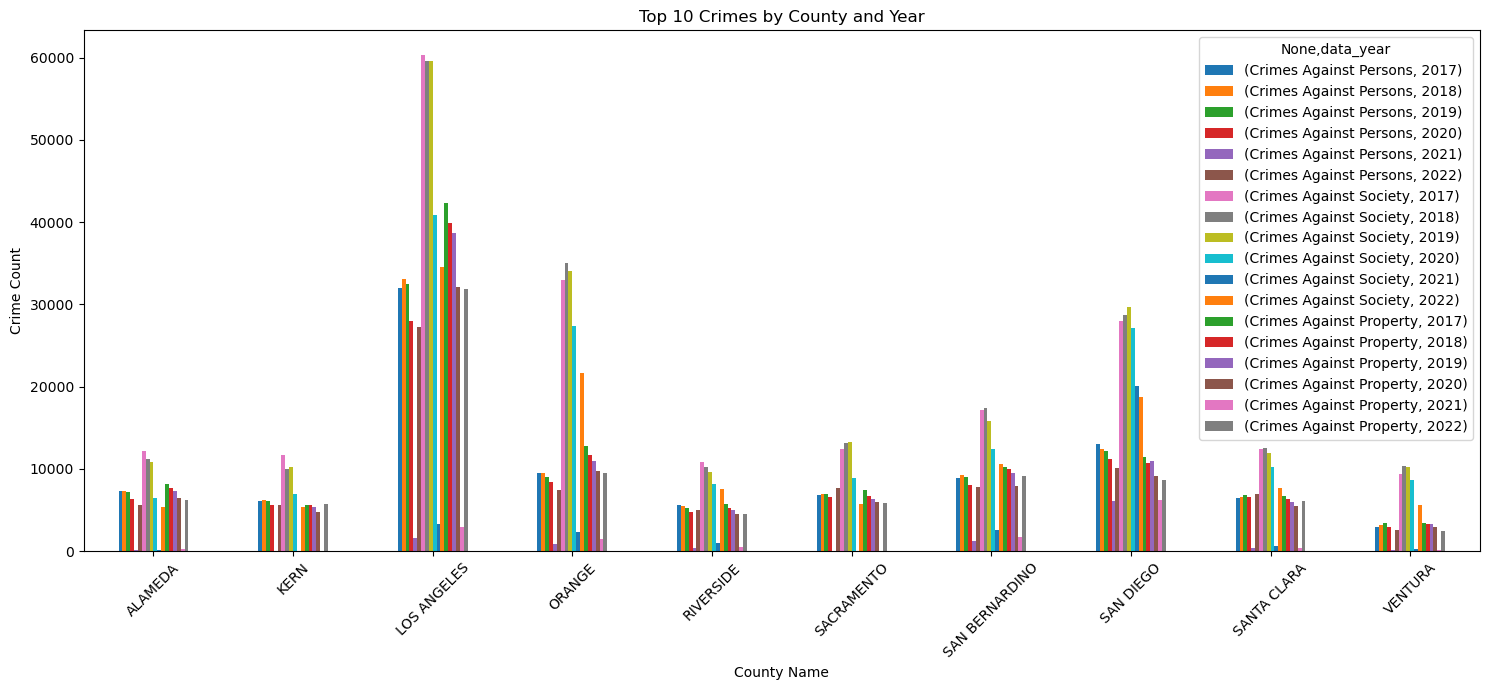

In [195]:
# Find the top 10 counties with the highest Crimes Against Society
top_10_Society = county_census_df.groupby("county_name")["Crimes Against Society"].sum().nlargest(10).index

# Filter the data for the top 10 counties
top_CASociety_data = county_census_df[county_census_df["county_name"].isin(top_10_Society)]


#create a multiplot bar chart with different colors for each year
top_CASociety_data.pivot(index='county_name', columns='data_year', values=['Crimes Against Persons','Crimes Against Society', 'Crimes Against Property']).plot(kind='bar', stacked=False, figsize=(15, 7))

#set the title and labels
plt.title("Top 10 Crimes by County and Year")
plt.xlabel("County Name")
plt.xticks(rotation=45)
plt.ylabel("Crime Count")
plt.tight_layout()

#save the figure
plt.savefig("output_data/Top10AllCrimes.png")

#show plot
plt.show()


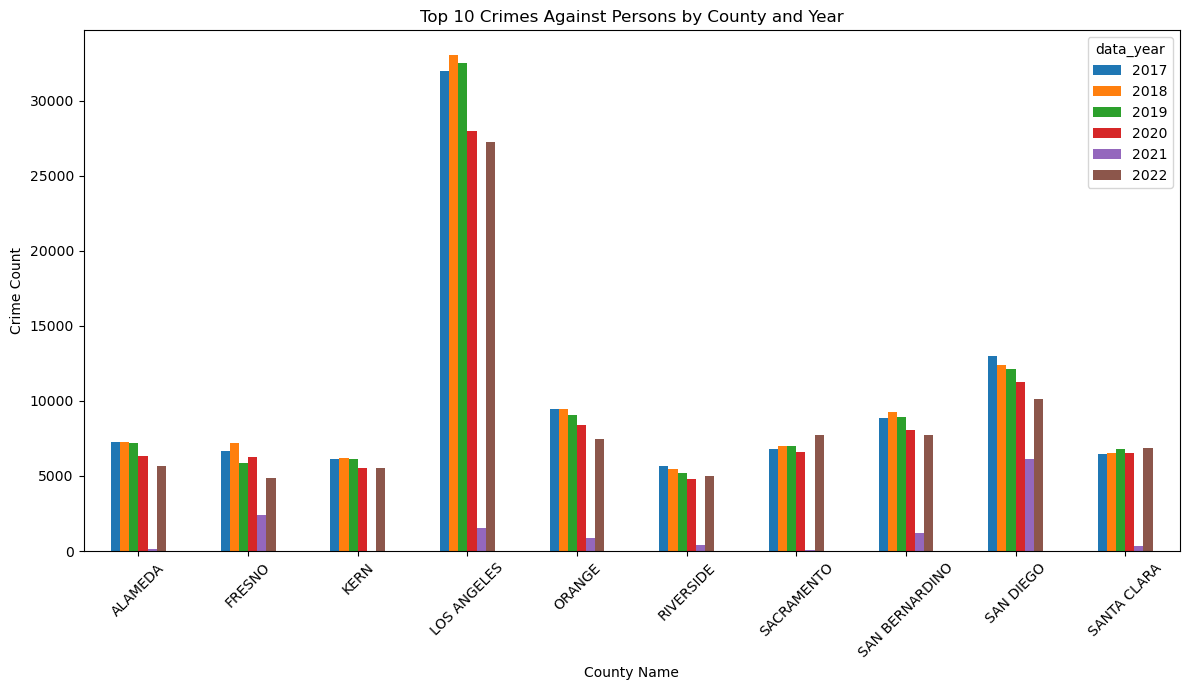

In [196]:
# Find the top 10 counties with the highest Crimes Against Society
top_10_CAPersons = county_census_df.groupby("county_name")["Crimes Against Persons"].sum().nlargest(10).index

# Filter the data for the top 10 counties
top_CAPersons_data = county_census_df[county_census_df["county_name"].isin(top_10_CAPersons)]


#create a multiplot bar chart with different colors for each year
top_CAPersons_data.pivot(index='county_name', columns='data_year', values='Crimes Against Persons').plot(kind='bar', stacked=False, figsize=(12, 7))

#set the title and labels
plt.title("Top 10 Crimes Against Persons by County and Year")
plt.xlabel("County Name")
plt.xticks(rotation=45)
plt.ylabel("Crime Count")
plt.tight_layout()

#save the figure
plt.savefig("output_data/Top10CAPersons.png")

#show plot
plt.show()


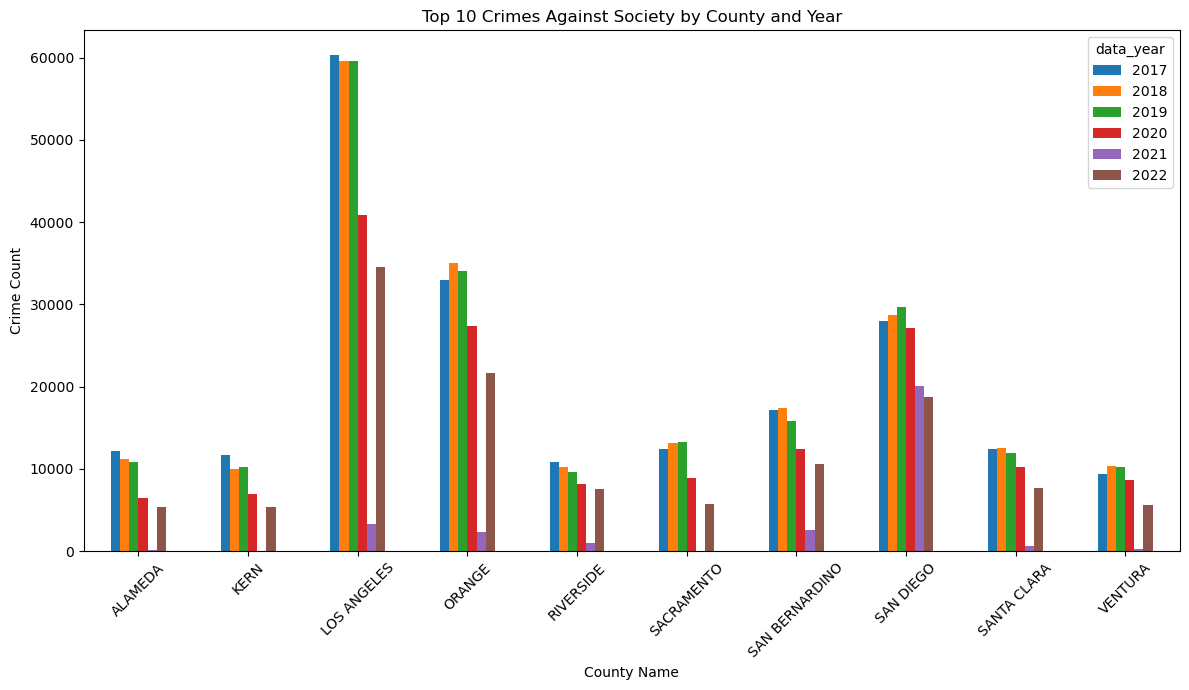

In [197]:
# Find the top 10 counties with the highest Crimes Against Society
top_10_Society = county_census_df.groupby("county_name")["Crimes Against Society"].sum().nlargest(10).index

# Filter the data for the top 10 counties
top_CASociety_data = county_census_df[county_census_df["county_name"].isin(top_10_Society)]


#create a multiplot bar chart with different colors for each year
top_CASociety_data.pivot(index='county_name', columns='data_year', values='Crimes Against Society').plot(kind='bar', stacked=False, figsize=(12, 7))

#set the title and labels
plt.title("Top 10 Crimes Against Society by County and Year")
plt.xlabel("County Name")
plt.xticks(rotation=45)
plt.ylabel("Crime Count")
plt.tight_layout()

#save the figure
plt.savefig("output_data/Top10CASociety.png")

#show plot
plt.show()


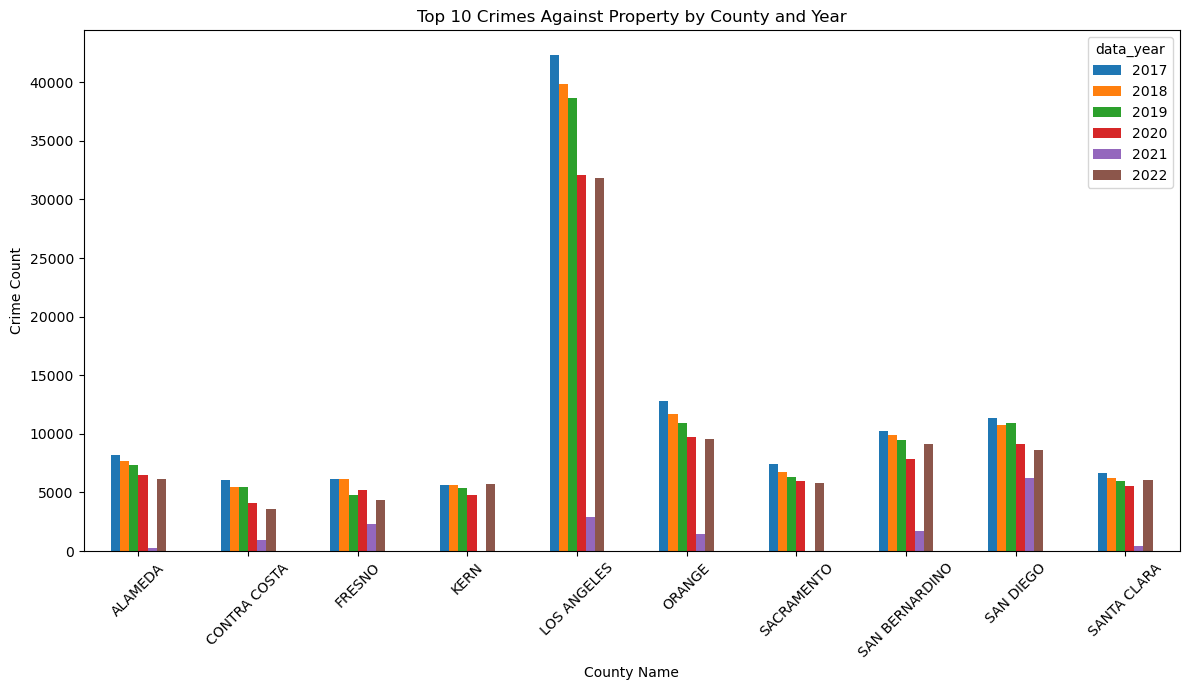

In [198]:
# Find the top 10 counties with the highest Crimes Against Society
top_10_Property = county_census_df.groupby("county_name")["Crimes Against Property"].sum().nlargest(10).index

# Filter the data for the top 10 counties
top_CASociety_data = county_census_df[county_census_df["county_name"].isin(top_10_Property)]


#create a multiplot bar chart with different colors for each year
top_CASociety_data.pivot(index='county_name', columns='data_year', values='Crimes Against Property').plot(kind='bar', stacked=False, figsize=(12, 7))

#set the title and labels
plt.title("Top 10 Crimes Against Property by County and Year")
plt.xlabel("County Name")
plt.xticks(rotation=45)
plt.ylabel("Crime Count")
plt.tight_layout()

#save the figure
plt.savefig("output_data/Top10CAProperty.png")

#show plot
plt.show()


In [199]:
#Grouped by county and sum cimes by county and get mean for poverty reate and population
per_county_allyears_df = county_census_df.groupby("county_name").agg({
    "Crimes Against Persons": "sum",
    "Crimes Against Society": "sum",
    "Crimes Against Property": "sum",
    "POVERTY_RATE": "mean",
    "POPULATION": "mean"
}).reset_index()

#Add Total Crime Count column and add data from combining the other three crime columns
per_county_allyears_df['Total Crime Count'] = per_county_allyears_df["Crimes Against Persons"] + per_county_allyears_df["Crimes Against Society"] + per_county_allyears_df["Crimes Against Property"]

#Display the new DataFrame
per_county_allyears_df.head()

,county_name,Crimes Against Persons,Crimes Against Society,Crimes Against Property,POVERTY_RATE,POPULATION,Total Crime Count
0,ALAMEDA,33756,46346,36062,12.0,1487888.0,116164
1,ALPINE,62,40,24,14.0,1160.0,126
2,AMADOR,621,1457,413,11.0,33228.0,2491
3,BUTTE,7225,18029,6457,21.0,214624.0,31711
4,CALAVERAS,1480,1169,605,10.0,44740.0,3254


The correlation between poverty rate and crime count is 0.02


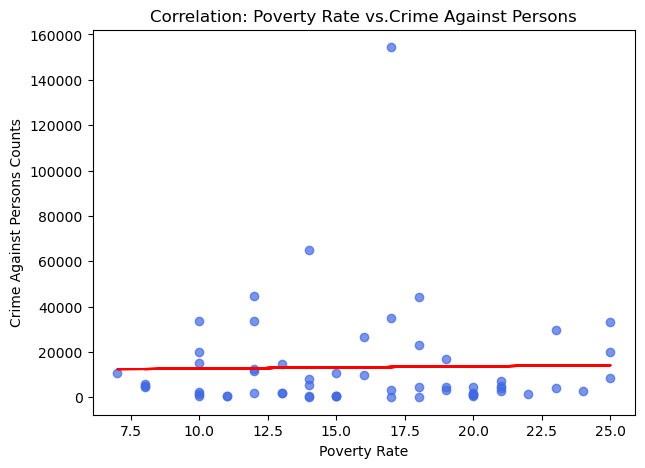

In [200]:
correlation = st.pearsonr(per_county_allyears_df['POVERTY_RATE'], per_county_allyears_df['Crimes Against Persons'])
print(f'The correlation between poverty rate and crime count is {round(correlation[0],2)}')

x_values = per_county_allyears_df['POVERTY_RATE']
y_values = per_county_allyears_df['Crimes Against Persons']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.figure(figsize=(7,5))
plt.scatter(x_values,y_values, color='royalblue', alpha=0.7)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Poverty Rate')
plt.ylabel('Crime Against Persons Counts')
plt.title('Correlation: Poverty Rate vs.Crime Against Persons')

#save the figure
plt.savefig("output_data/cor_poverty_vs_CAPersons.png")

#show plot
plt.show()

The correlation between poverty rate and crime count is -0.04


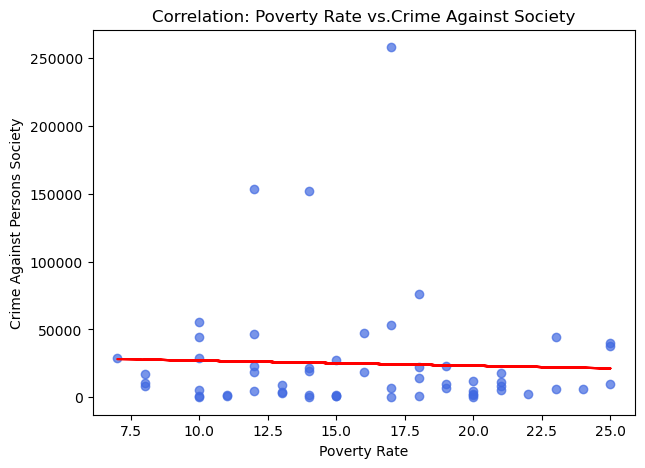

In [201]:
correlation = st.pearsonr(per_county_allyears_df['POVERTY_RATE'], per_county_allyears_df['Crimes Against Society'])
print(f'The correlation between poverty rate and crime count is {round(correlation[0],2)}')

x_values = per_county_allyears_df['POVERTY_RATE']
y_values = per_county_allyears_df['Crimes Against Society']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.figure(figsize=(7,5))
plt.scatter(x_values,y_values, color='royalblue', alpha=0.7)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Poverty Rate')
plt.ylabel('Crime Against Persons Society')
plt.title('Correlation: Poverty Rate vs.Crime Against Society')

#save the figure
plt.savefig("output_data/cor_poverty_vs_CASociety.png")

#show plot
plt.show()

The correlation between poverty rate and crime count is -0.0


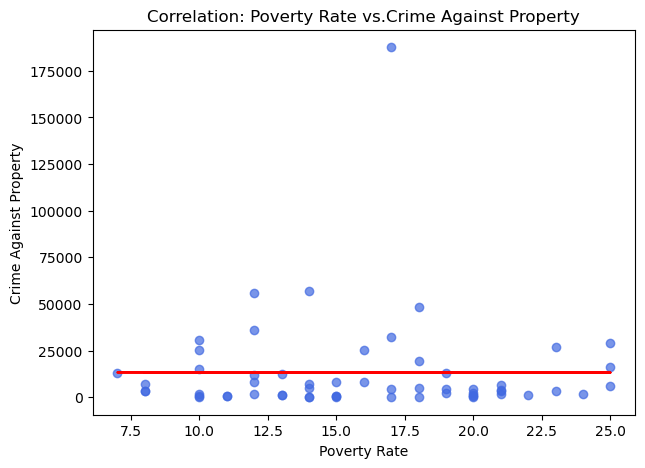

In [202]:
correlation = st.pearsonr(per_county_allyears_df['POVERTY_RATE'], per_county_allyears_df['Crimes Against Property'])
print(f'The correlation between poverty rate and crime count is {round(correlation[0],2)}')

x_values = per_county_allyears_df['POVERTY_RATE']
y_values = per_county_allyears_df['Crimes Against Property']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.figure(figsize=(7,5))
plt.scatter(x_values,y_values, color='royalblue', alpha=0.7)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Poverty Rate')
plt.ylabel('Crime Against Property')
plt.title('Correlation: Poverty Rate vs.Crime Against Property')

#save the figure
plt.savefig("output_data/cor_poverty_vs_CAProperty.png")

#show plot
plt.show()

The correlation between poverty rate and crime count is -0.01


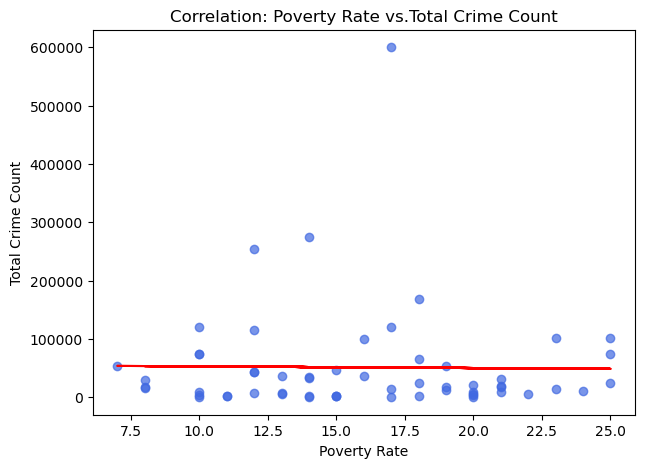

In [203]:
correlation = st.pearsonr(per_county_allyears_df['POVERTY_RATE'], per_county_allyears_df['Total Crime Count'])
print(f'The correlation between poverty rate and crime count is {round(correlation[0],2)}')

x_values = per_county_allyears_df['POVERTY_RATE']
y_values = per_county_allyears_df['Total Crime Count']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.figure(figsize=(7,5))
plt.scatter(x_values,y_values, color='royalblue', alpha=0.7)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Poverty Rate')
plt.ylabel('Total Crime Count')
plt.title('Correlation: Poverty Rate vs.Total Crime Count')

#save the figure
plt.savefig("output_data/cor_poverty_vs_TotalCrime.png")

#show plot
plt.show()

The correlation between poverty rate and crime count is 0.98


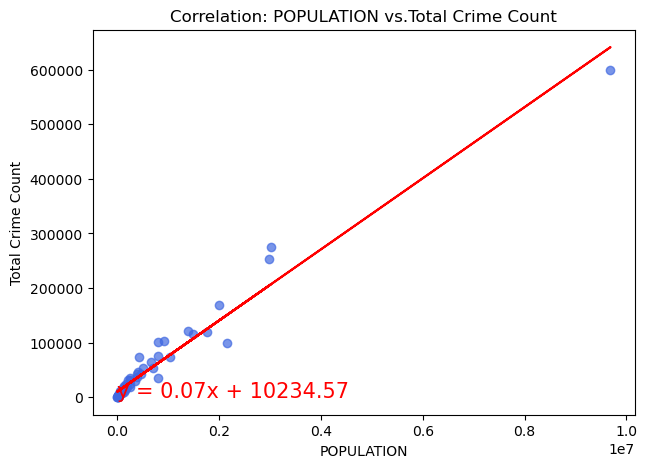

In [204]:
correlation = st.pearsonr(per_county_allyears_df['POPULATION'], per_county_allyears_df['Total Crime Count'])
print(f'The correlation between poverty rate and crime count is {round(correlation[0],2)}')

x_values = per_county_allyears_df['POPULATION']
y_values = per_county_allyears_df['Total Crime Count']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.figure(figsize=(7,5))
plt.scatter(x_values,y_values, color='royalblue', alpha=0.7)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('POPULATION')
plt.ylabel('Total Crime Count')
plt.title('Correlation: POPULATION vs.Total Crime Count')

#save the figure
plt.savefig("output_data/cor_pop_vs_TotalCrime.png")

#show plot
plt.show()


In [205]:
#Read saved data 
county_crime_type_df = pd.read_csv("Resources/county_level_consolidated_all_agencies_all_available_years.csv")

#Display sample data
county_crime_type_df.head()

,county_name,data_year,Crimes Against Persons,Crimes Against Society,Crimes Against Property
0,ALAMEDA,2017,7284,12156,8169
1,ALAMEDA,2018,7242,11225,7670
2,ALAMEDA,2019,7188,10867,7321
3,ALAMEDA,2020,6301,6507,6477
4,ALAMEDA,2021,105,183,278


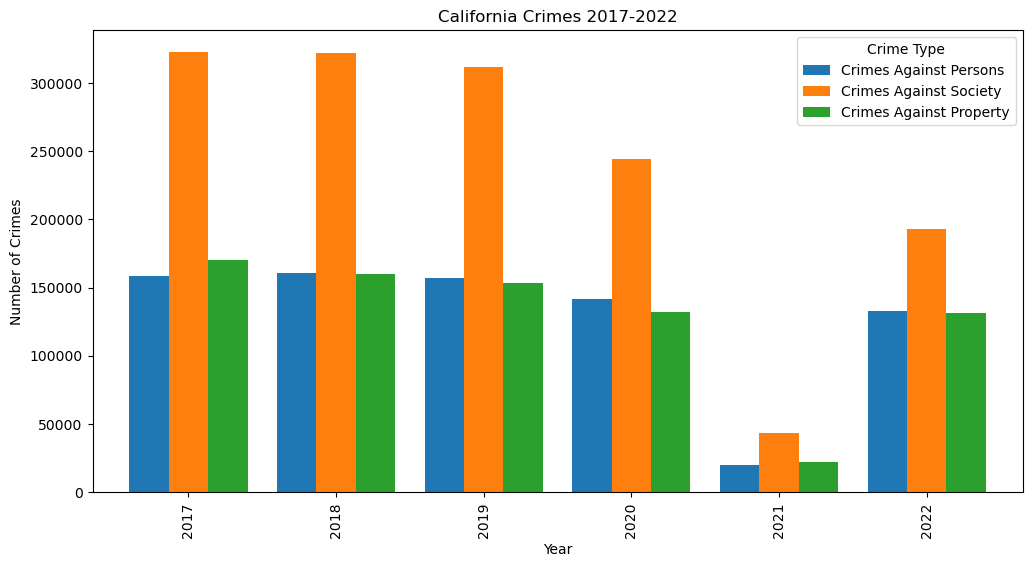

In [206]:
#To plot pie chart for each year in california, grouped by data_year
grouped_county_crime_df = county_crime_type_df.groupby('data_year')[['Crimes Against Persons', 'Crimes Against Society', 'Crimes Against Property']].sum()

#create bar chart to compare overall crime for 2017-2022
grouped_county_crime_df.plot(kind='bar', figsize=(12,6), width=0.8)
plt.title('California Crimes 2017-2022')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(title='Crime Type', loc='upper right')

#save the figure
plt.savefig("output_data/CA_Crime_byYear.png")

#show plot
plt.show()
